In [19]:
# Victor Z, Jaron T
# UW-Madison, 2024
# linear regression for heat capacity

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, linregress, probplot
import statsmodels.api as sm
import pandas as pd

In [21]:
# generate data (true model is Cp=a0+a1*T+a2*T^2)
# CP in cal/mol-K and T in K
a0 = 0.6190e+1
a1 = 0.2923e-2
a2 = -0.7052e-6
theta = np.array([a0, a1, a2])

# 3 sets of experiments at T=300K, T=400K, and T=500K
n = 10
N = 3 * n
x1 = np.linspace(300, 300, n)
x2 = np.linspace(600, 600, n)
x3 = np.linspace(900, 900, n)
x = np.concatenate((x1, x2, x3))

# generate true outputs
np.random.seed(0)
y1 = a0 + a1 * x1 + a2 * x1**2
y2 = a0 + a1 * x2 + a2 * x2**2
y3 = a0 + a1 * x3 + a2 * x3**2
ytrue = np.concatenate((y1, y2, y3))

# add random noise to true outputs
# there are differences with Matlab because of different seed
sigma = 0.1
y = ytrue + np.random.normal(0, sigma, N)

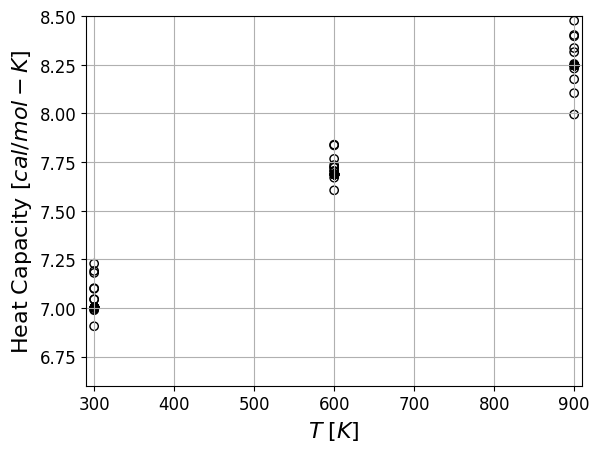

In [22]:
# Visualize data
plt.figure(1)
plt.scatter(x, y, facecolors='none', edgecolors='black', linewidths=1)
plt.scatter(x, ytrue, color='black', linewidths=1)
plt.xlabel(r'$T\; [K]$', fontsize=16)
plt.ylabel(r'Heat Capacity $[cal/mol-K]$', fontsize=16)
plt.grid(True)
plt.box(True)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.axis([290, 910, 6.6, 8.5])
plt.show()

In [23]:
# construct input and output data matrix for MLE
X = np.column_stack((np.ones(N), x, x**2))
Y = y

# assume noise variance is not known and obtain best fit parameters
# by solving SSE minimization problem
thetaest = np.linalg.inv(X.T @ X) @ X.T @ Y

# confirm that this minimizer is unique
eigenvalues = np.linalg.eigvals(X.T @ X)

# get model predictions
Yhat = X @ thetaest

# get residuals
e = Y - Yhat

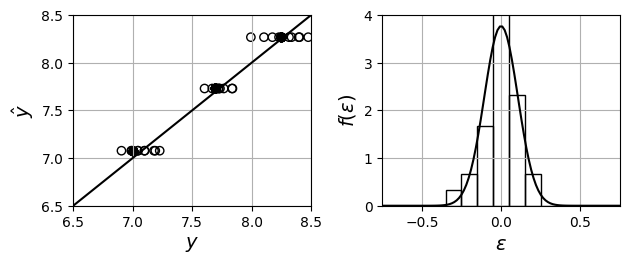

In [24]:
# visualize fit
plt.figure(2)
plt.subplot(2, 2, 1)
plt.scatter(Y, Yhat, facecolors='none', edgecolors='black')
plt.scatter(ytrue, Yhat, color='black')
plt.plot([6.5, 8.5], [6.5, 8.5], 'k')
plt.grid(True)
plt.xlabel(r'$y$', fontsize=14)
plt.ylabel(r'$\hat{y}$', fontsize=14)
plt.axis([6.5, 8.5, 6.5, 8.5])

mu, std = norm.fit(e)
plt.subplot(2, 2, 2)
plt.hist(e, bins=np.arange(-0.75, 0.85, 0.1), density=True, edgecolor='black', facecolor='none', linewidth=1)
xx = np.linspace(-0.75, 0.75, 100)
plt.plot(xx, norm.pdf(xx, mu, std), 'k-', linewidth=1.5)
plt.axis([-0.75, 0.75, 0, 4])
plt.grid(True)
plt.xlabel(r'$\epsilon$', fontsize=14)
plt.ylabel(r'$f(\epsilon)$', fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
# assume variance of error is from output measurement
sig2 = np.var(e)
sigest = np.sqrt(sig2)

# get covariance matrix for parameters
C = np.linalg.inv(X.T @ X) * sig2

print(pd.DataFrame(C))

# determine Fisher information matrix
I = np.linalg.inv(C)

print(pd.DataFrame(I))

# get R2
Ybar = np.mean(Y)
Sm = np.linalg.norm(Yhat - Ybar)**2
Se = np.linalg.norm(Y - Yhat)**2
Sy = np.linalg.norm(Y - Ybar)**2

R2 = Sm / Sy
print(R2)

              0             1             2
0  2.126862e-02 -7.835808e-05  6.218896e-08
1 -7.835808e-05  3.047259e-07 -2.487558e-10
2  6.218896e-08 -2.487558e-10  2.072965e-13
              0             1             2
0  2.680004e+03  1.608003e+06  1.125602e+09
1  1.608003e+06  1.125602e+09  8.683214e+11
2  1.125602e+09  8.683214e+11  7.091291e+14
0.9549409323779036


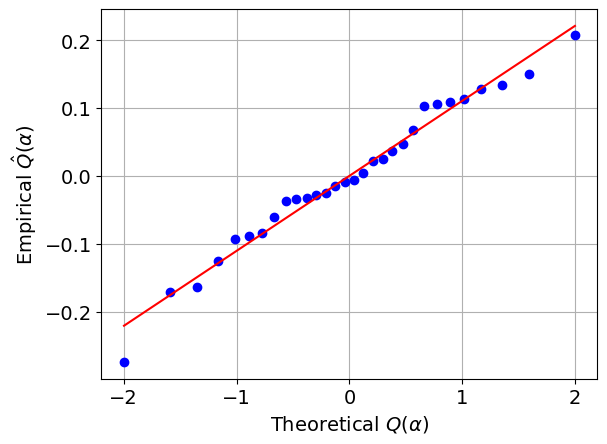

In [29]:
# get qqplot of residuals
plt.figure(3)
probplot(e, dist="norm", plot=plt)
plt.title(None)
plt.xlabel('Theoretical $Q(\\alpha)$', fontsize=14)
plt.ylabel('Empirical $\\hat{Q}(\\alpha)$', fontsize=14)
plt.grid(True)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.show()


In [27]:
# try statsmodels built-in functions and compare with our calculations
X = np.column_stack((x, x**2))
Y = y
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     286.1
Date:                Fri, 28 Jun 2024   Prob (F-statistic):           6.70e-19
Time:                        16:12:35   Log-Likelihood:                 24.817
No. Observations:                  30   AIC:                            -43.63
Df Residuals:                      27   BIC:                            -39.43
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3102      0.154     41.048      0.0